# Final Submission Notebook 

Growth Factor AI Challenge 

Authors: Benjamin R. Kurland, Lisette del Pino 

Feb 23 2025

In [40]:
import geopandas as gpd
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.neighbors import BallTree


### read data

In [7]:
directory = r"C:\Users\jmkur\Downloads\hackathon\traffic_data_sample\traffic_data_sample\traffic_data_sample.shp"
gdf = gpd.read_file(directory)

### EDA

In [8]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2825075 entries, 0 to 2825074
Data columns (total 23 columns):
 #   Column      Dtype   
---  ------      -----   
 0   id          int64   
 1   mode        object  
 2   country_co  object  
 3   state_code  object  
 4   county_fip  int64   
 5   segment_na  object  
 6   osm_id      int64   
 7   highway     object  
 8   segment_le  float64 
 9   segment_id  int64   
 10  year        int64   
 11  month       int64   
 12  match_dir   int64   
 13  day_type    int64   
 14  day_part    int64   
 15  trips_volu  int64   
 16  trips_samp  int64   
 17  vmt         int64   
 18  created_at  object  
 19  updated_at  object  
 20  trips_vo_1  int64   
 21  trips_sa_1  int64   
 22  geometry    geometry
dtypes: float64(1), geometry(1), int64(14), object(7)
memory usage: 495.7+ MB


There are 5 states in the sample data

In [9]:
gdf["state_code"].value_counts()

state_code
FL    942622
NY    697071
GA    675498
MA    362789
WV    147095
Name: count, dtype: int64

Most trip volumes are small, and the distribution is right skewed with some routes with very large trip volumes in the tens of thousands.

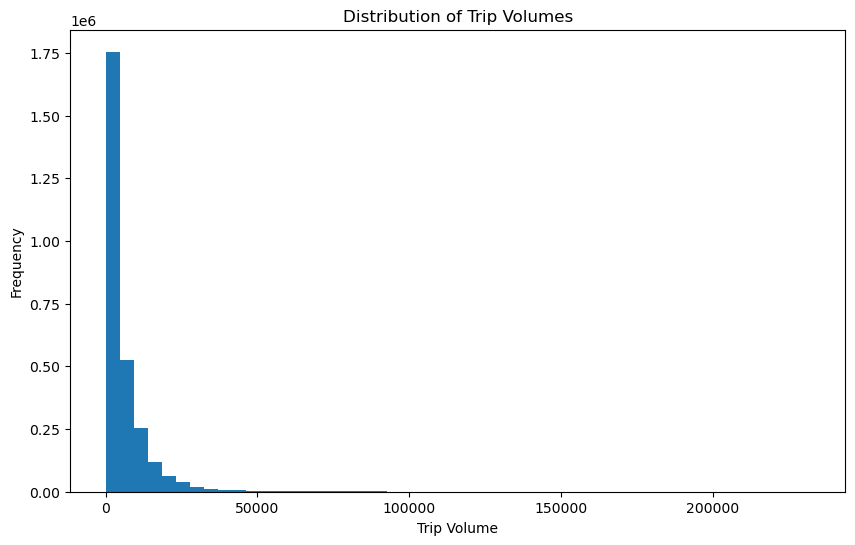

In [16]:
plt.figure(figsize=(10, 6))
plt.hist(gdf['trips_volu'], bins=50)
plt.title('Distribution of Trip Volumes')
plt.xlabel('Trip Volume')
plt.ylabel('Frequency')
plt.show()

### Highway Field

Remove non-vehicle segments such as 'pedestrian', 'cycleway', 'footway', etc. The counts for these segments are low, and we keep almost all our data.

In [22]:
gdf['highway'].value_counts()

highway
TERTIARY          1056950
SECONDARY          637880
PRIMARY            545880
UNCLASSIFIED       192014
TRUNK              167243
MOTORWAY            80435
MOTORWAY_LINK       73346
PRIMARY_LINK        26728
TRUNK_LINK          19845
SECONDARY_LINK      12544
TERTIARY_LINK        7768
LIVING_STREET        3886
TRACK                 347
FOOTWAY                94
PATH                   44
CYCLEWAY               32
PEDESTRIAN             24
BRIDLEWAY              15
Name: count, dtype: int64

In [23]:
gdf = gdf[~gdf["highway"].isin(['FOOTWAY','PATH','CYCLEWAY','PEDESTRIAN','BRIDLEWAY'])]

### match_dir field
There are three values for the match_dir field.

According to the provided definition, (1) is with the segment's direction of travel; (2) is the against the segment's direction of travel; (3) is bidirectional travel along the segment.

With the direction of travel (1) and bidirectional (3) both have ~40% of segments while opposite direction (2) has ~20%.

In [28]:
gdf['match_dir'].value_counts()

match_dir
3    1079255
1    1075935
2     669676
Name: count, dtype: int64

### osm_id field

There appear to be duplicte rows, which have the same osm_id field. For example, osm_id 20105512 is duplicated 267 times.  For each duplicate, all fields appear the same except match_dir and trip_volume, and geometry. It's unclear why the geometry would be changing for the same segment. Although, deduplication may be reasonable, since the reason for the duplication is unclear, we for now do not dedupe. It is also unclear how to pick the geometry in the deduplication process besides arbitrarily selecting one. 

In [58]:
gdf['osm_id'].value_counts()

osm_id
20105512     267
713665540    213
15579619     210
15501230     207
132986391    198
            ... 
9382739        1
9179515        1
761101711      1
20158320       1
9337368        1
Name: count, Length: 496176, dtype: int64

In [72]:
list(gdf.query("osm_id == 20105512").head(50)['geometry'])

[<LINESTRING (-76.131 44.218, -76.13 44.218, -76.128 44.219)>,
 <LINESTRING (-76.131 44.218, -76.13 44.218, -76.128 44.219)>,
 <LINESTRING (-76.131 44.218, -76.13 44.218, -76.128 44.219)>,
 <LINESTRING (-76.221 44.186, -76.221 44.186)>,
 <LINESTRING (-76.221 44.186, -76.221 44.186)>,
 <LINESTRING (-76.221 44.186, -76.221 44.186)>,
 <LINESTRING (-76.168 44.209, -76.167 44.209)>,
 <LINESTRING (-76.168 44.209, -76.167 44.209)>,
 <LINESTRING (-76.168 44.209, -76.167 44.209)>,
 <LINESTRING (-76.206 44.193, -76.205 44.193, -76.205 44.194, -76.204 44.194)>,
 <LINESTRING (-76.206 44.193, -76.205 44.193, -76.205 44.194, -76.204 44.194)>,
 <LINESTRING (-76.206 44.193, -76.205 44.193, -76.205 44.194, -76.204 44.194)>,
 <LINESTRING (-76.121 44.223, -76.121 44.223)>,
 <LINESTRING (-76.121 44.223, -76.121 44.223)>,
 <LINESTRING (-76.121 44.223, -76.121 44.223)>,
 <LINESTRING (-76.251 44.167, -76.25 44.167)>,
 <LINESTRING (-76.251 44.167, -76.25 44.167)>,
 <LINESTRING (-76.251 44.167, -76.25 44.167)>

If deduping is performed, then over half the entries in the data set would be removed, (down to 1.2 million from 2.8 million).

In [ ]:
gdf_deduped = gdf.sort_values("trips_volu",ascending=False).drop_duplicates(subset=["osm_id","match_dir"])

In [65]:
len(gdf),len(gdf_deduped)

(2824866, 1218375)

### Data Partitioning

Partition segments by county to make search faster. Opening a file with all counties takes 2 minutes while opening the file for 1 county takes under 2 seconds.

In [ ]:
def get_center_lat_long(line):
    '''aggregate segment into single point--used for estimating county center'''
    x, y = line.xy
    x, y = np.array(x), np.array(y)
    return np.mean(x),np.mean(y)

for county in tqdm(set(gdf['county_fip'])):
    county_df = gdf.query(f"county_fip == {county}")
    
    county_df["lat"], county_df["long"] = zip(*county_df['geometry'].apply(get_center_lat_long))
    columns = ['id','osm_id','county_fip','state_code','highway','segment_na','lat','long','geometry', 'trips_volu','match_dir']
    county_df[columns].to_parquet(f"county_data/county_{county}.parquet")    

  0%|          | 0/357 [00:00<?, ?it/s]C:\Users\jmkur\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\jmkur\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
  0%|          | 1/357 [00:01<08:17,  1.40s/it]C:\Users\jmkur\AppData\Roaming\Python\Python312\site-packages\geopandas\geodatafra

The algorithm will convolve points along each segment. Extracting these points from the geometry is computationally expensive, and will be required in our algorithm. We therefore extract these points and cache them rather than computing them at runtime. Again, we do this on a county by county basis.

In [ ]:
def extract_coordinates_from_geometries(df):
    """
    Extract coordinates from LineString geometries into a DataFrame with one row per point.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing 'geometry', 'osm_id', and 'county_fip' columns
        where 'geometry' contains LineString objects
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with columns ['lat', 'long', 'osm_id', 'county_fip']
        containing one row per coordinate point
    """
    # Initialize lists to store the flattened data
    coordinates = []
    
    # Process each geometry
    for _, row in df.iterrows():
        line = row['geometry']
        x, y = line.xy
        points = list(zip(x, y))

        # Add all points from this line with their metadata
        coordinates.extend([
            {
                'lat': point[1],
                'long': point[0],
                'id': row['id'],
                'trips_volu':row['trips_volu']
            }
            for point in points
        ])
    
    # Create DataFrame from the collected data
    return pd.DataFrame(coordinates)

for county in tqdm(set(gdf['county_fip'])):
    county_df = gdf.query(f"county_fip == {county}")
    
    county_points = extract_coordinates_from_geometries(
        county_df[['geometry', 'id','trips_volu']]
    )    

    county_points.to_parquet(f"county_data_points/county_{county}_points.parquet") 

100%|██████████| 357/357 [05:43<00:00,  1.04it/s]


In [ ]:

def get_neighbors(county,center,radius_miles):
    
    '''
    use k-d tree to get all points within a certain radius of an inputted point
    specify county and radius

    returns rows of county dataframe which are within the distance from inputted point
    '''

    data = pd.read_parquet(f"county_data_points/county_{county}_points.parquet") 

    #haversine distance metric requires distance to be in radians
    MILES_RADIAN_CONVERSION = 3958.8
    radius_radians = radius_miles / MILES_RADIAN_CONVERSION

    #initialize kd tree
    rng = np.random.RandomState(0)
    tree = BallTree(data[['lat','long']].values, leaf_size=20, metric='haversine')       
    
    #perform the search
    ind,dist  = tree.query_radius(center, r=radius_radians,return_distance=True)       
    ind,dist = ind[0],dist[0]

    print(f"Number of Points Within {radius_miles} Miles: {len(ind)}")
    

    neighbors_df = data.iloc[ind].copy()
    neighbors_df['distances'] = dist * MILES_RADIAN_CONVERSION
    return neighbors_df


#middlesex county, Tasty Burger, cambridge ma
tasty_burger_center = [42.372604805799256, -71.11990992133708]
neighbors_df = get_neighbors(county = "25017",center = [tasty_burger_center], radius_miles=.25)


Number of Points Within 0.25 Miles: 12


There are 12 points (belonging to 8 segments) within a quarter mile radius of the Tasty Burger in Harvard Square. 

In [85]:
neighbors_df['id'].value_counts()

id
9500405     2
10082875    2
9500379     2
10082896    2
10365865    1
10365866    1
10462103    1
10463142    1
Name: count, dtype: int64

Now several of the segments correspond to the same geometry, but have different match_directions. We want the segment on the same side of the street as the Tasty Burger, so we choose the row with match_dir 1.

In [113]:
county = "25017"
county_data = pd.read_parquet(f"county_data/county_{county}.parquet").drop_duplicates(subset=["osm_id","match_dir","geometry"]).query("match_dir==1")
county_data_neighbors = county_data[county_data["id"].isin(set(neighbors_df['id']))]
county_data_neighbors

,id,osm_id,county_fip,state_code,highway,segment_na,lat,long,geometry,trips_volu,match_dir
1871545,9500379,426593995,25017,MA,PRIMARY,Mount Auburn Street / 426593995 / 1,-71.120386,42.372664,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\x00\x00...,7515,1
1896988,10082875,426593987,25017,MA,SECONDARY,John F. Kennedy Street / 426593987 / 1,-71.119775,42.373021,b'\x01\x02\x00\x00\x00\x08\x00\x00\x00\xfd\xff...,11857,1
1911392,10365865,352191241,25017,MA,SECONDARY,John F. Kennedy Street / 352191241 / 1,-71.120328,42.372356,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\xfd\xff...,12076,1
1916834,10462103,426594766,25017,MA,PRIMARY,Mount Auburn Street / 426594766 / 1,-71.119727,42.372409,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\xfd\xff...,7102,1


### Now we visualize these nearby segments on the map.

In [116]:
import plotly.express as px
import plotly.graph_objects as go
from shapely import wkb
from shapely.geometry import Point, LineString
import pandas as pd
import numpy as np
import math

def miles_to_degrees(miles, latitude):
    """Convert miles to degrees of latitude/longitude"""
    # Length of a degree of latitude in miles
    lat_miles = 69.172
    # Length of a degree of longitude in miles (varies with latitude)
    lon_miles = abs(math.cos(math.radians(latitude)) * 69.172)
    
    return {
        'lat': miles / lat_miles,
        'lon': miles / lon_miles
    }

def create_circle_coords(center, radius_miles):
    """Create coordinates for a circle with given center and radius"""
    # Convert radius to degrees (approximate)
    deg = miles_to_degrees(radius_miles, center[0])
    
    # Generate points around the circle
    angles = np.linspace(0, 2*np.pi, 100)
    circle_points = []
    
    for angle in angles:
        dx = deg['lon'] * np.cos(angle)
        dy = deg['lat'] * np.sin(angle)
        circle_points.append([center[1] + dx, center[0] + dy])
    
    return circle_points

def plot_geometries(df, geometry_column='geometry', zoom=10, center=None, add_circle=None):
    """
    Plot geometries using Plotly Scattermapbox
    
    Parameters:
    df: pandas DataFrame containing geometry column
    geometry_column: name of the column containing WKB geometry data
    zoom: initial zoom level for the map
    center: list [lat, lon] or dict {'lat': lat, 'lon': lon} for map center
    add_circle: dict with 'center': [lat, lon], 'radius': radius in miles
    """
    
    # Convert center to dict if it's a list
    if isinstance(center, (list, tuple)):
        center = {'lat': center[0], 'lon': center[1]}
    
    # Convert binary geometries to coordinates
    def extract_coordinates(geom_binary):
        try:
            # Parse WKB geometry
            geometry = wkb.loads(geom_binary)
            
            # Extract coordinates based on geometry type
            if geometry.type == 'Point':
                return [geometry.x], [geometry.y]
            elif geometry.type in ['LineString', 'Polygon']:
                coords = list(geometry.coords) if geometry.type == 'LineString' else list(geometry.exterior.coords)
                return [x for x, y in coords], [y for x, y in coords]
            elif geometry.type.endswith('MultiLineString'):
                coords = []
                for line in geometry.geoms:
                    coords.extend(list(line.coords))
                return [x for x, y in coords], [y for x, y in coords]
            else:
                return [], []
        except Exception as e:
            print(f"Error processing geometry: {e}")
            return [], []

    # Extract coordinates from all geometries
    coordinates = [extract_coordinates(geom) for geom in df[geometry_column]]
    lons, lats = zip(*coordinates)
    
    # Flatten coordinates and remove empty lists
    all_lons = [lon for sublist in lons for lon in sublist if lon]
    all_lats = [lat for sublist in lats for lat in sublist if lat]
    
    # Calculate center if not provided
    if center is None and all_lons and all_lats:
        center = {
            'lon': np.mean(all_lons),
            'lat': np.mean(all_lats)
        }
    elif center is None:
        center = {'lon': 0, 'lat': 0}

    # Create the map
    fig = go.Figure()

    # Add geometries to the map
    for i, (lon_list, lat_list) in enumerate(zip(lons, lats)):
        if lon_list and lat_list:  # Only add if coordinates exist
            fig.add_trace(go.Scattermapbox(
                lon=lon_list,
                lat=lat_list,
                mode='lines+markers',
                marker={'size': 10},
                line={'width': 2},
                name=f'Segment {i+1}'
            ))

    # Add circle if requested
    if add_circle:
        circle_coords = create_circle_coords(
            [center['lat'], center['lon']], 
            add_circle
        )
        
        circle_lons, circle_lats = zip(*[(x, y) for x, y in circle_coords])
        
        # Add the circle
        fig.add_trace(go.Scattermapbox(
            lon=circle_lons,
            lat=circle_lats,
            mode='lines',
            line={'width': 2, 'color': 'black'},
            name=None,
            showlegend=False,
        ))
        
        # Add center point
        fig.add_trace(go.Scattermapbox(
            lon=[center['lon']],
            lat=[center['lat']],
            mode='markers',
            marker={'size': 12, 'color': 'black'},
            name=None,
            showlegend=False,
        ))

    # Update layout
    fig.update_layout(
        mapbox={
            'style': 'open-street-map',
            'center': center,
            'zoom': zoom
        },
        margin={'r': 0, 't': 0, 'l': 0, 'b': 0},
        showlegend=True
    )

    return fig

# Example usage:
fig = plot_geometries(county_data_neighbors, 
                      zoom=16,
                      center=tasty_burger_center,
                      add_circle=0.25/3)  
fig.show()

C:\Users\jmkur\AppData\Local\Temp\ipykernel_22928\3278246417.py:60: ShapelyDeprecationWarning:

The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.

C:\Users\jmkur\AppData\Local\Temp\ipykernel_22928\3278246417.py:62: ShapelyDeprecationWarning:

The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.

C:\Users\jmkur\AppData\Local\Temp\ipykernel_22928\3278246417.py:63: ShapelyDeprecationWarning:

The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.



Next we aggregate the trip volumes for the segments in the given radius. For now, we do a simple average, but this could be improved with a Parzen Window/density estimation.

In [117]:
neighbors_df[neighbors_df['id'].isin(set(county_data_neighbors['id']))]['trips_volu'].mean()

9653.666666666666

Once we've aggregated the nearby trip volumes, we compute the impression score. We would like the impression score to be between 0 and 1. To perform the calibration of this score, we compute a set of thresholdholds based on the distribution of trip volumes in the county. The reason that this calibration is done at the county level is because it seems reasonable that a client may want to find a piece of property nearby at the local level, rather than a national search. The kth percentile of trip volumes corresponds to the kth impression score.

Note that there are other ways to calibrate the impression score. For example, instead of constraining the trip volumes, we could use the constraint than an equal proportion of segments have each impression score. 

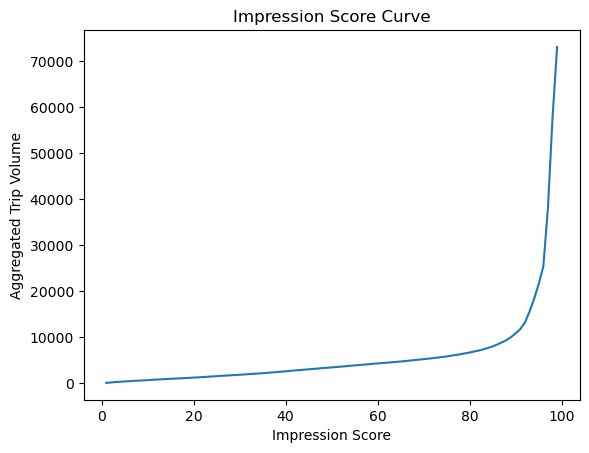

In [132]:
percentiles_x = np.linspace(1,99,99)
percentiles_y = np.percentile(county_data['trips_volu'],percentiles)

plt.plot(percentiles_x,percentiles_y)
plt.xlabel('Impression Score')
plt.ylabel('Aggregated Trip Volume')
plt.title("Impression Score Curve")
plt.show()